In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("takehome_user_engagement.csv", index_col='time_stamp', parse_dates=True)

In [3]:
df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [4]:
df.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [5]:
df.user_id.unique()

array([    1,     2,     3, ..., 11998, 11999, 12000], dtype=int64)

In [6]:
df_user = pd.read_csv('takehome_users.csv', encoding='latin1', index_col="object_id")

In [7]:
df_user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
df_user['creation_time'].describe()

count                   12000
unique                  11996
top       2014-02-11 17:57:53
freq                        2
Name: creation_time, dtype: object

# Fist deal with nan valeus:

In [9]:
df.isnull().sum()

user_id    0
visited    0
dtype: int64

In [10]:
df_user.isnull().sum()

creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

<AxesSubplot:xlabel='object_id'>

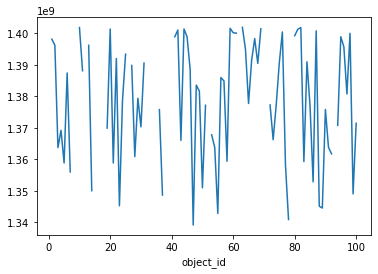

In [11]:
df_user['last_session_creation_time'][:100].plot()


<AxesSubplot:xlabel='object_id'>

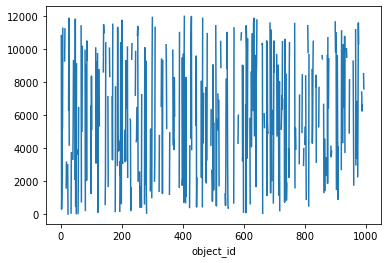

In [12]:
df_user['invited_by_user_id'][:1000].plot()

In [13]:
# Function to fill missing values with average of closest values
def fill_with_closest_avg(df, column_name):
    for i in df[df[column_name].isna()].index:
        # Find the index of the next non-na value
        next_valid = df[column_name].iloc[i:].first_valid_index()
        # Find the index of the previous non-na value
        prev_valid = df[column_name].iloc[:i].last_valid_index()

        next_val = df.at[next_valid, column_name] if next_valid is not None else np.nan
        prev_val = df.at[prev_valid, column_name] if prev_valid is not None else np.nan

        # Calculate average if both values are not NaN
        if not np.isnan(next_val) and not np.isnan(prev_val):
            avg_val = (next_val + prev_val) / 2
        elif np.isnan(next_val) and not np.isnan(prev_val):
            avg_val = prev_val
        elif not np.isnan(next_val) and np.isnan(prev_val):
            avg_val = next_val
        else:
            avg_val = np.nan

        # Fill missing value with average
        df.at[i, column_name] = avg_val

# Applying the function to your DataFrame
fill_with_closest_avg(df_user, 'last_session_creation_time')
fill_with_closest_avg(df_user, 'invited_by_user_id')

In [14]:
df_user.isnull().sum()

creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64

## Defining the target variable, "adopted_user":

Fist resample the number of visits weekly:

In [15]:
weekly_visits = df.groupby(['user_id', pd.Grouper(freq='W')])['visited'].count()
weekly_visits.head(20)

user_id  time_stamp
1        2014-04-27    1
2        2013-11-17    1
         2013-12-01    1
         2013-12-15    1
         2013-12-29    1
         2014-01-05    1
         2014-01-12    1
         2014-02-09    3
         2014-02-16    2
         2014-03-09    1
         2014-03-16    1
         2014-04-06    1
3        2013-03-24    1
4        2013-05-26    1
5        2013-01-27    1
6        2013-12-22    1
7        2012-12-23    1
10       2013-01-20    1
         2013-01-27    1
         2013-02-03    1
Name: visited, dtype: int64

We are looking interested in number of visits greater that 3:

In [16]:
# Define a function to resample within each group and add the new column
def resample_and_evaluate(group):
    resampled = group.resample('W').count()
    resampled['more_than_3_visits'] = resampled['visited'] >= 3
    return resampled

# Group by 'user_id' and apply the resampling and evaluation function
result = df.groupby('user_id').apply(resample_and_evaluate)

In [17]:
print(result.head(40))
print(result.columns)



                    user_id  visited  more_than_3_visits
user_id time_stamp                                      
1       2014-04-27        1        1               False
2       2013-11-17        1        1               False
        2013-11-24        0        0               False
        2013-12-01        1        1               False
        2013-12-08        0        0               False
        2013-12-15        1        1               False
        2013-12-22        0        0               False
        2013-12-29        1        1               False
        2014-01-05        1        1               False
        2014-01-12        1        1               False
        2014-01-19        0        0               False
        2014-01-26        0        0               False
        2014-02-02        0        0               False
        2014-02-09        3        3                True
        2014-02-16        2        2               False
        2014-02-23        0    

In [18]:
result.drop(['user_id'], inplace=True, axis=1)
result_reset = result.reset_index()
print(len(result_reset['user_id'].unique()))
result_reset.head(20)

8823


,user_id,time_stamp,visited,more_than_3_visits
0,1,2014-04-27,1,False
1,2,2013-11-17,1,False
2,2,2013-11-24,0,False
3,2,2013-12-01,1,False
4,2,2013-12-08,0,False
5,2,2013-12-15,1,False
6,2,2013-12-22,0,False
7,2,2013-12-29,1,False
8,2,2014-01-05,1,False
9,2,2014-01-12,1,False


In [19]:
# Group by 'user_id' and check for any True values in 'more_than_3_visits'
adopted_users = result_reset.groupby('user_id')['more_than_3_visits'].any()

# Convert boolean to integer (True to 1, False to 0)
adopted_users = adopted_users.astype(int).reset_index()

print(adopted_users.head(10))


   user_id  more_than_3_visits
0        1                   0
1        2                   1
2        3                   0
3        4                   0
4        5                   0
5        6                   0
6        7                   0
7       10                   1
8       11                   0
9       13                   0


Some user_id are missing from user_id columns. Let's include them and set their values to 0.

In [20]:

# Define the full range of user IDs (replace max_id with your specific maximum ID)
max_id = adopted_users['user_id'].max()
all_user_ids = pd.DataFrame({'user_id': range(1, max_id + 1)})

# Merge the DataFrames, filling in missing values with 0
complete_users = all_user_ids.merge(adopted_users, on='user_id', how='left').fillna(0)

# Convert the 'more_than_3_visits' back to integers (it was converted to float by fillna)
complete_users['more_than_3_visits'] = complete_users['more_than_3_visits'].astype(int)

# Display the first 10 rows
print(complete_users.head(10))

   user_id  more_than_3_visits
0        1                   0
1        2                   1
2        3                   0
3        4                   0
4        5                   0
5        6                   0
6        7                   0
7        8                   0
8        9                   0
9       10                   1


## Cleaning the data

In [21]:
df_user.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


WE can drop name and email as they are not good predectors:

In [22]:
df_user.drop(['name', 'email'], inplace=True, axis=1)

In [23]:
df_user.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Feature engineering: 

In [24]:
# df_user['creation_time_year'] = pd.to_datetime(df_user['creation_time']).dt.year
df_user['creation_time_month'] = pd.to_datetime(df_user['creation_time']).dt.month
df_user['creation_time_weekday'] = pd.to_datetime(df_user['creation_time']).dt.weekday
df_user['creation_time_day'] = pd.to_datetime(df_user['creation_time']).dt.day
df_user.drop(['creation_time'], inplace=True, axis=1)

In [25]:
df_user.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_time_month,creation_time_weekday,creation_time_day
object_id,,,,,,,,,
1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,4,1,22
2,ORG_INVITE,1.396238e+09,0,0,1,316.0,11,4,15
3,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,1,19
4,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,5,1,21
5,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,3,17


To create a new feature based on last_session_creation_time, let's call it time_since_last_session. This feature will measure the duration from the last session to the current moment: time_since_last_session.

In [26]:
df_user['time_since_last_session'] = df_user['last_session_creation_time'].max() - df_user['last_session_creation_time']

In [27]:
df_user.drop(['last_session_creation_time'], inplace=True, axis=1)

In [28]:
df_user = pd.get_dummies(df_user, columns=['creation_source'], drop_first=True)

In [29]:
df_user.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_time_month,creation_time_weekday,creation_time_day,time_since_last_session,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,
1,1,0,11,10803.0,4,1,22,3927920.0,0,0,0,0
2,0,0,1,316.0,11,4,15,5829226.0,1,0,0,0
3,0,0,94,1525.0,3,1,19,38331838.0,1,0,0,0
4,0,0,1,5151.0,5,1,21,32856562.0,0,0,0,0
5,0,0,193,5240.0,1,3,17,43217070.0,0,0,0,0


In [30]:
df_user.isnull().sum()

opted_in_to_mailing_list              0
enabled_for_marketing_drip            0
org_id                                0
invited_by_user_id                    0
creation_time_month                   0
creation_time_weekday                 0
creation_time_day                     0
time_since_last_session               0
creation_source_ORG_INVITE            0
creation_source_PERSONAL_PROJECTS     0
creation_source_SIGNUP                0
creation_source_SIGNUP_GOOGLE_AUTH    0
dtype: int64

## Data Splitting
Before training models, split your dataset into a training set and a testing set. This will allow you to train your model on one subset of the data and then test its performance on a separate subset.

In [31]:
from sklearn.model_selection import train_test_split
y = complete_users['more_than_3_visits']

X = df_user
y.head(-20)

0        0
1        1
2        0
3        0
4        0
        ..
11975    0
11976    0
11977    0
11978    0
11979    0
Name: more_than_3_visits, Length: 11980, dtype: int32

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection:

### Decision Trees
Pros: Easy to interpret, can handle non-linear relationships.
Cons: Prone to overfitting.
Usage: Good for understanding the decision-making process.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')



In [34]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=2)

In [35]:
best_dt = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best parameters found:", best_params)


Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [36]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

y_pred = best_dt.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9458333333333333
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2108
           1       0.86      0.66      0.75       292

    accuracy                           0.95      2400
   macro avg       0.91      0.82      0.86      2400
weighted avg       0.94      0.95      0.94      2400



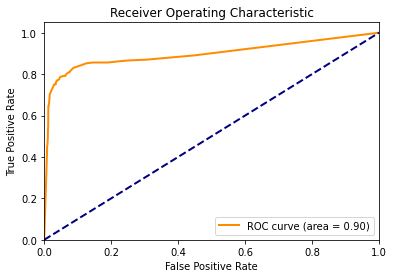

In [37]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)



plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [38]:
# Assuming 'best_dt' is your trained Decision Tree model
feature_importances = best_dt.feature_importances_

# Create a pandas series to visualize the importances
features = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)

print(features)

time_since_last_session               0.668221
creation_time_month                   0.185120
creation_time_day                     0.041893
org_id                                0.034598
invited_by_user_id                    0.023178
creation_source_PERSONAL_PROJECTS     0.015009
creation_time_weekday                 0.014290
creation_source_SIGNUP_GOOGLE_AUTH    0.007474
enabled_for_marketing_drip            0.003304
creation_source_SIGNUP                0.003196
creation_source_ORG_INVITE            0.002822
opted_in_to_mailing_list              0.000894
dtype: float64


# Feature Importance Analysis

## 1. time_since_last_session (0.668221)
- **High Importance**: Strongly correlates with the target variable, possibly reflecting user engagement or churn.
- **Implication**: Longer intervals might indicate user disengagement, while shorter ones could suggest active users.

## 2. creation_time_month (0.185120)
- **Moderate Importance**: Shows that the month of account creation significantly influences predictions.
- **Implication**: Indicates potential seasonal trends or monthly variations in user behavior.
